## Imports

In [1]:
#####################################################
##################### Imports #######################
#####################################################

import os
import time
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix, classification_report
)
from torchsummary import summary


try:
    %cd 'Projeto Final/Fruits Classification/transfer_learning/multiclass_classification'
    print('\n')
except:
    pass

!ls
print('\n')

#!nvidia-smi

## Checking GPU and CPU

In [ ]:
print("Available CPUs:", os.cpu_count())
print("\n--------------------------\n")

if torch.cuda.is_available():
    print(f"Available GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"{i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPU available.")

Available CPUs: 128

--------------------------

Available GPUs: 3
0: Tesla T4
1: Tesla T4
2: Tesla T4


## Functions

In [5]:
#####################################################
##################### Metrics #######################
#####################################################

def compute_accuracy(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    total = labels.size(0)
    return correct / total


#####################################################
#################### Checkpoint #####################
#####################################################

def save_checkpoint(model, optimizer, history, epoch, path='checkpoint.pth'):
    """Save model, optimizer state and history."""
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"[Checkpoint] Saved at epoch {epoch+1} → {path}")

def load_checkpoint(model, optimizer, path="checkpoint.pth", device='cpu'):
    """Load model, optimizer state, epoch and history from checkpoint."""
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Continue from next epoch
    history = checkpoint['history']
    print(f"[Checkpoint] Loaded from '{path}', resuming at epoch {start_epoch}.")
    return model, optimizer, start_epoch, history


#####################################################
###################### Train ########################
#####################################################

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.long().to(device)  # Para CrossEntropyLoss, labels devem ser long sem one-hot

        optimizer.zero_grad()
        outputs = model(images)  # logits, shape [batch, num_classes]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item() * labels.size(0)
        batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

        running_loss += batch_loss
        running_corrects += batch_acc
        total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def evaluate_model(model, loader, criterion, device, desc="Evaluation"):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc=desc, leave=False):
            images = images.to(device)
            labels = labels.long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_loss = loss.item() * labels.size(0)
            batch_acc = compute_accuracy(outputs, labels) * labels.size(0)

            running_loss += batch_loss
            running_corrects += batch_acc
            total_samples += labels.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples

    return epoch_loss, epoch_acc

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs, start_epoch=0, history=None, 
                patience=5, checkpoint_path='checkpoint.pth', best_model_path='best_model.pth'):
    """Main training loop with checkpoint saving and early stopping."""

    if history is None:
        history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': [],
            'epoch_time': []
        }

    best_val_loss = np.inf
    patience_counter = 0

    model.to(device)

    for epoch in range(start_epoch, epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        start_time = time.time()

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device, desc="Validation")

        epoch_time = time.time() - start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['epoch_time'].append(epoch_time)

        # Checkpoint Save
        save_checkpoint(model, optimizer, history, epoch, path=checkpoint_path)

        # Early Stopping Check
        if val_loss < best_val_loss: #(best_val_loss + best_val_loss * 0.05):
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), best_model_path)
            print(f"[EarlyStopping] New best model saved (val_loss: {val_loss:.4f}) → {best_model_path}")
        else:
            patience_counter += 1
            print(f"[EarlyStopping] No improvement... ({patience_counter}/{patience} patience)")

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
              f"Time: {epoch_time/60:.2f}min")

        if patience_counter >= patience:
            print(f"[EarlyStopping] Stopping early at epoch {epoch+1}.")
            break

    return history


#####################################################
###################### Evaluate #####################
#####################################################

def evaluate_on_test(model, test_loader, device, class_names=['class0', 'class1', 'class2', 'class3', 'class4']):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)  # logits
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

    print("\nTest Metrics:")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"Precision:  {precision:.4f}")
    print(f"Recall:     {recall:.4f}")
    print(f"F1 Score:   {f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    cm = confusion_matrix(all_labels, all_preds, normalize='pred')
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, cmap='Oranges', xticklabels=class_names, yticklabels=class_names,
                vmin=0, vmax=1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Split)')
    plt.tight_layout()
    plt.show()


#####################################################
####################### Plot ########################
#####################################################

def plot_training_history(history):
    sns.set(style='whitegrid')

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    sns.reset_defaults()
    
def show_random_test_predictions(model, test_loader, device, class_names=['Other Fruits', 'Banana'], threshold=0.5):
    model.eval()
    samples = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            preds = (outputs.cpu().numpy().flatten() >= threshold).astype(int)

            for img, true, pred in zip(images.cpu(), labels.cpu().numpy(), preds):
                samples.append((img, true, pred))

    selected_samples = random.sample(samples, 12)

    plt.figure(figsize=(12, 9))
    for i, (img, true, pred) in enumerate(selected_samples):
        image = img.numpy().transpose(1, 2, 0)  # C,H,W → H,W,C
        image = (image * 0.5) + 0.5  # Un-normalizar de [-1,1] para [0,1]

        plt.subplot(3, 4, i + 1)
        plt.imshow(np.clip(image, 0, 1))
        true_class = class_names[true]
        pred_class = class_names[pred]
        color = 'green' if true_class == pred_class else 'red'
        plt.title(f"True: {true_class}\nPred: {pred_class}", color=color, fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Resnet18

In [40]:
#####################################################
################## Data Preparation #################
#####################################################

# Image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Dataset paths
data_dir = "../../dataset_multiclass"  # Change path if needed
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Datasets and Dataloaders
BATCH_SIZE = 64
NUM_WORKERS = 32

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=valid_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)


#####################################################
################ Transfer Learning ##################
#####################################################

# Load pretrained ResNet18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace fully connected layer for multiclass classification
num_ftrs = model.fc.in_features
num_classes = len(train_dataset.classes) 
model.fc = nn.Linear(num_ftrs, num_classes)

# Multi-GPU support (DataParallel)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

summary(model, input_size=(3, 224, 224))

Using 3 GPUs!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          36,864
       BatchNorm2d-8           [-1, 64, 56, 56]             128
              ReLU-9           [-1, 64, 56, 56]               0
           Conv2d-10           [-1, 64, 56, 56]          36,864
      BatchNorm2d-11           [-1, 64, 56, 56]             128
             ReLU-12           [-1, 64, 56, 56]               0
       BasicBlock-13           [-1, 64, 56, 56]               0
           Conv2d-14     

In [29]:
#####################################################
####################### Training ###################
#####################################################

criterion = nn.CrossEntropyLoss()  # Multiclass loss (expects raw logits)
optimizer = optim.Adam(model.module.fc.parameters(), lr=0.0001) if isinstance(model, nn.DataParallel) else optim.Adam(model.fc.parameters(), lr=0.0001)

EPOCHS = 50

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
    checkpoint_path='checkpoint_resnet18.pth',
    best_model_path='best_resnet18.pth'
)


Epoch 1/50


[Checkpoint] Saved at epoch 1 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 1.2331) → best_resnet18.pth
Train Loss: 1.5301, Train Acc: 0.3256, Val Loss: 1.2331, Val Acc: 0.5550, Time: 0.30min

Epoch 2/50


[Checkpoint] Saved at epoch 2 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 1.0206) → best_resnet18.pth
Train Loss: 1.3234, Train Acc: 0.4966, Val Loss: 1.0206, Val Acc: 0.6900, Time: 0.27min

Epoch 3/50


[Checkpoint] Saved at epoch 3 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.8760) → best_resnet18.pth
Train Loss: 1.1909, Train Acc: 0.5705, Val Loss: 0.8760, Val Acc: 0.7350, Time: 0.27min

Epoch 4/50


[Checkpoint] Saved at epoch 4 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.8178) → best_resnet18.pth
Train Loss: 1.1002, Train Acc: 0.6089, Val Loss: 0.8178, Val Acc: 0.7700, Time: 0.25min

Epoch 5/50


[Checkpoint] Saved at epoch 5 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.7554) → best_resnet18.pth
Train Loss: 1.0476, Train Acc: 0.6324, Val Loss: 0.7554, Val Acc: 0.7600, Time: 0.27min

Epoch 6/50


[Checkpoint] Saved at epoch 6 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.7013) → best_resnet18.pth
Train Loss: 1.0007, Train Acc: 0.6468, Val Loss: 0.7013, Val Acc: 0.7750, Time: 0.26min

Epoch 7/50


[Checkpoint] Saved at epoch 7 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.6764) → best_resnet18.pth
Train Loss: 0.9684, Train Acc: 0.6508, Val Loss: 0.6764, Val Acc: 0.8100, Time: 0.29min

Epoch 8/50


[Checkpoint] Saved at epoch 8 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.6486) → best_resnet18.pth
Train Loss: 0.9484, Train Acc: 0.6578, Val Loss: 0.6486, Val Acc: 0.8000, Time: 0.30min

Epoch 9/50


[Checkpoint] Saved at epoch 9 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.6368) → best_resnet18.pth
Train Loss: 0.9285, Train Acc: 0.6648, Val Loss: 0.6368, Val Acc: 0.8200, Time: 0.28min

Epoch 10/50


[Checkpoint] Saved at epoch 10 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.6077) → best_resnet18.pth
Train Loss: 0.9007, Train Acc: 0.6721, Val Loss: 0.6077, Val Acc: 0.7800, Time: 0.29min

Epoch 11/50


[Checkpoint] Saved at epoch 11 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5901) → best_resnet18.pth
Train Loss: 0.8962, Train Acc: 0.6757, Val Loss: 0.5901, Val Acc: 0.8100, Time: 0.28min

Epoch 12/50


[Checkpoint] Saved at epoch 12 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.8897, Train Acc: 0.6769, Val Loss: 0.5923, Val Acc: 0.7950, Time: 0.30min

Epoch 13/50


[Checkpoint] Saved at epoch 13 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5851) → best_resnet18.pth
Train Loss: 0.8745, Train Acc: 0.6806, Val Loss: 0.5851, Val Acc: 0.7900, Time: 0.28min

Epoch 14/50


[Checkpoint] Saved at epoch 14 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5741) → best_resnet18.pth
Train Loss: 0.8647, Train Acc: 0.6855, Val Loss: 0.5741, Val Acc: 0.7900, Time: 0.26min

Epoch 15/50


[Checkpoint] Saved at epoch 15 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5629) → best_resnet18.pth
Train Loss: 0.8669, Train Acc: 0.6798, Val Loss: 0.5629, Val Acc: 0.8350, Time: 0.29min

Epoch 16/50


[Checkpoint] Saved at epoch 16 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5532) → best_resnet18.pth
Train Loss: 0.8485, Train Acc: 0.6872, Val Loss: 0.5532, Val Acc: 0.8150, Time: 0.28min

Epoch 17/50


[Checkpoint] Saved at epoch 17 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.8435, Train Acc: 0.6894, Val Loss: 0.5601, Val Acc: 0.8100, Time: 0.29min

Epoch 18/50


[Checkpoint] Saved at epoch 18 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5479) → best_resnet18.pth
Train Loss: 0.8361, Train Acc: 0.6912, Val Loss: 0.5479, Val Acc: 0.8200, Time: 0.32min

Epoch 19/50


[Checkpoint] Saved at epoch 19 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5414) → best_resnet18.pth
Train Loss: 0.8263, Train Acc: 0.6913, Val Loss: 0.5414, Val Acc: 0.8250, Time: 0.29min

Epoch 20/50


[Checkpoint] Saved at epoch 20 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.8221, Train Acc: 0.6955, Val Loss: 0.5511, Val Acc: 0.8250, Time: 0.29min

Epoch 21/50


[Checkpoint] Saved at epoch 21 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5403) → best_resnet18.pth
Train Loss: 0.8089, Train Acc: 0.7016, Val Loss: 0.5403, Val Acc: 0.8350, Time: 0.26min

Epoch 22/50


[Checkpoint] Saved at epoch 22 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5386) → best_resnet18.pth
Train Loss: 0.8208, Train Acc: 0.6928, Val Loss: 0.5386, Val Acc: 0.8250, Time: 0.28min

Epoch 23/50


[Checkpoint] Saved at epoch 23 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5330) → best_resnet18.pth
Train Loss: 0.8113, Train Acc: 0.6962, Val Loss: 0.5330, Val Acc: 0.8150, Time: 0.29min

Epoch 24/50


[Checkpoint] Saved at epoch 24 → checkpoint_resnet18.pth
[EarlyStopping] New best model saved (val_loss: 0.5147) → best_resnet18.pth
Train Loss: 0.8139, Train Acc: 0.6996, Val Loss: 0.5147, Val Acc: 0.8350, Time: 0.30min

Epoch 25/50


[Checkpoint] Saved at epoch 25 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7998, Train Acc: 0.7051, Val Loss: 0.5304, Val Acc: 0.8150, Time: 0.26min

Epoch 26/50


[Checkpoint] Saved at epoch 26 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.8031, Train Acc: 0.7014, Val Loss: 0.5329, Val Acc: 0.8050, Time: 0.26min

Epoch 27/50


[Checkpoint] Saved at epoch 27 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 0.8054, Train Acc: 0.7018, Val Loss: 0.5223, Val Acc: 0.8250, Time: 0.27min

Epoch 28/50


[Checkpoint] Saved at epoch 28 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (4/5 patience)
Train Loss: 0.7941, Train Acc: 0.7087, Val Loss: 0.5182, Val Acc: 0.8150, Time: 0.27min

Epoch 29/50


[Checkpoint] Saved at epoch 29 → checkpoint_resnet18.pth
[EarlyStopping] No improvement... (5/5 patience)
Train Loss: 0.8029, Train Acc: 0.7000, Val Loss: 0.5219, Val Acc: 0.8250, Time: 0.27min
[EarlyStopping] Stopping early at epoch 29.


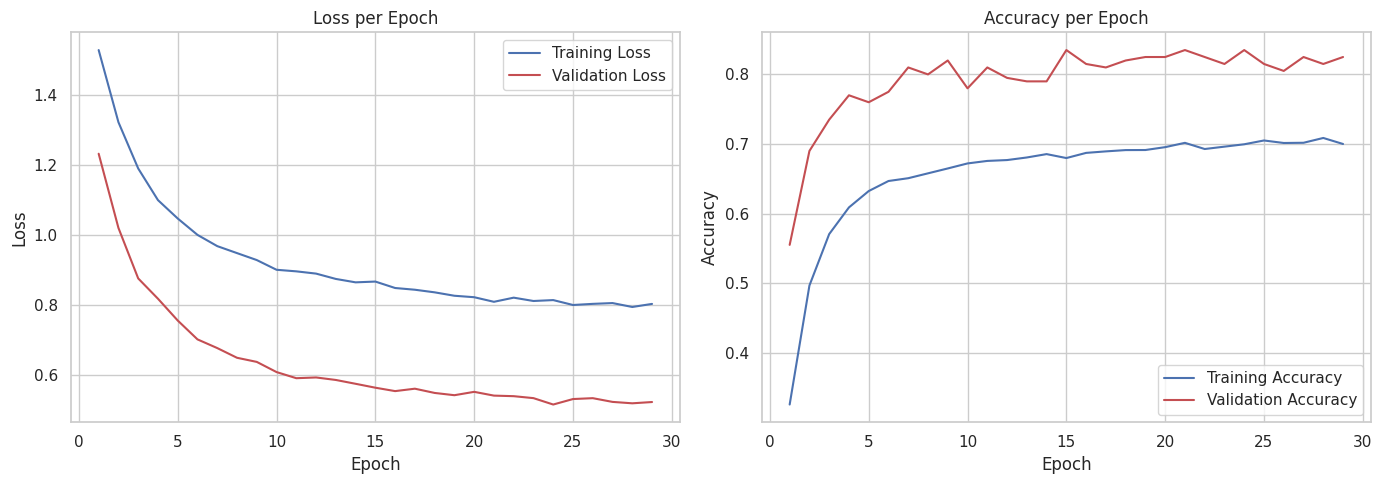

In [30]:
# Plot training history
plot_training_history(history)


Test Metrics:
Accuracy:   0.8600
Precision:  0.8696
Recall:     0.8600
F1 Score:   0.8612

Classification Report:
              precision    recall  f1-score   support

       Apple     0.6818    0.7500    0.7143        20
      Banana     0.8333    1.0000    0.9091        20
       Grape     0.9444    0.8500    0.8947        20
       Mango     0.9412    0.8000    0.8649        20
  Strawberry     0.9474    0.9000    0.9231        20

    accuracy                         0.8600       100
   macro avg     0.8696    0.8600    0.8612       100
weighted avg     0.8696    0.8600    0.8612       100



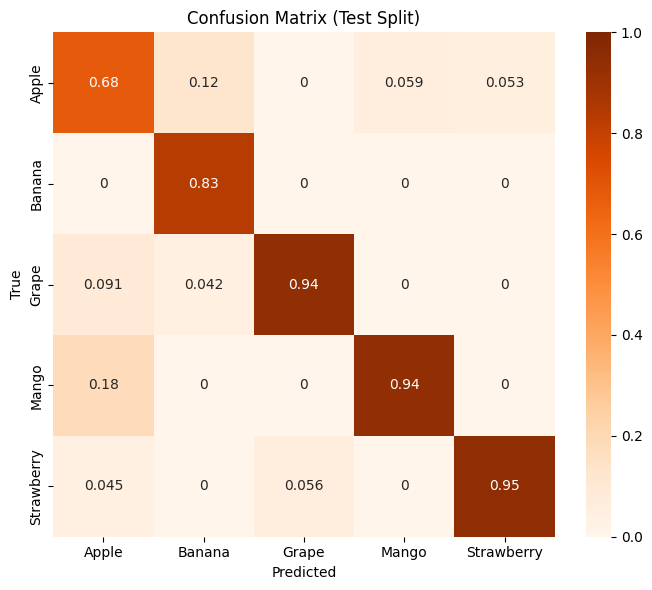

In [31]:
# Final test evaluation
evaluate_on_test(model, test_loader, device, class_names=train_dataset.classes)

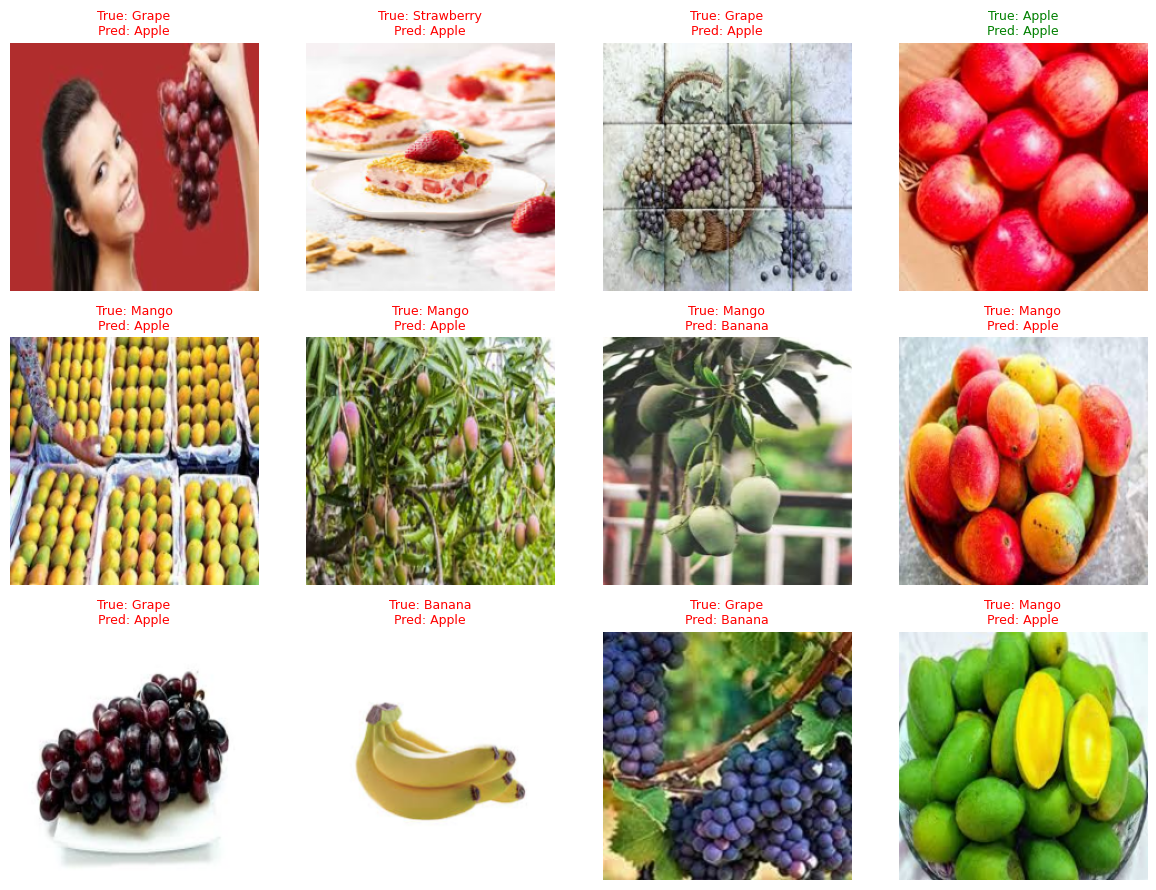

In [32]:
show_random_test_predictions(model, test_loader, device, class_names=train_dataset.classes)

# Resnet50

In [33]:
#####################################################
################## Data Preparation #################
#####################################################

# Image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

valid_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Dataset paths
data_dir = "../../dataset_multiclass"  # Change path if needed
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Datasets and Dataloaders
BATCH_SIZE = 64
NUM_WORKERS = 32

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_test_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=valid_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

#####################################################
################ Transfer Learning ##################
#####################################################

# Load pretrained ResNet18
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace fully connected layer for multiclass classification
num_ftrs = model.fc.in_features
num_classes = len(train_dataset.classes)  
model.fc = nn.Linear(num_ftrs, num_classes)  

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

model = model.to(device)

Using 3 GPUs!


In [34]:
#####################################################
####################### Training ####################
#####################################################

criterion = nn.CrossEntropyLoss()  # Multiclass loss (expects raw logits, no softmax)
optimizer = optim.Adam(model.module.fc.parameters(), lr=0.0001) if isinstance(model, nn.DataParallel) else optim.Adam(model.fc.parameters(), lr=0.0001)
EPOCHS = 50

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=EPOCHS,
    checkpoint_path='checkpoint_resnet50.pth',
    best_model_path='best_resnet50.pth'
)


Epoch 1/50


[Checkpoint] Saved at epoch 1 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 1.3956) → best_resnet50.pth
Train Loss: 1.5048, Train Acc: 0.4411, Val Loss: 1.3956, Val Acc: 0.6600, Time: 0.44min

Epoch 2/50


[Checkpoint] Saved at epoch 2 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 1.2345) → best_resnet50.pth
Train Loss: 1.3379, Train Acc: 0.5973, Val Loss: 1.2345, Val Acc: 0.7250, Time: 0.44min

Epoch 3/50


[Checkpoint] Saved at epoch 3 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 1.1216) → best_resnet50.pth
Train Loss: 1.2173, Train Acc: 0.6392, Val Loss: 1.1216, Val Acc: 0.7400, Time: 0.43min

Epoch 4/50


[Checkpoint] Saved at epoch 4 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 1.0212) → best_resnet50.pth
Train Loss: 1.1390, Train Acc: 0.6497, Val Loss: 1.0212, Val Acc: 0.7500, Time: 0.43min

Epoch 5/50


[Checkpoint] Saved at epoch 5 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.9666) → best_resnet50.pth
Train Loss: 1.0765, Train Acc: 0.6659, Val Loss: 0.9666, Val Acc: 0.7600, Time: 0.42min

Epoch 6/50


[Checkpoint] Saved at epoch 6 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.9024) → best_resnet50.pth
Train Loss: 1.0269, Train Acc: 0.6753, Val Loss: 0.9024, Val Acc: 0.7450, Time: 0.45min

Epoch 7/50


[Checkpoint] Saved at epoch 7 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.8454) → best_resnet50.pth
Train Loss: 0.9880, Train Acc: 0.6847, Val Loss: 0.8454, Val Acc: 0.7800, Time: 0.42min

Epoch 8/50


[Checkpoint] Saved at epoch 8 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.7950) → best_resnet50.pth
Train Loss: 0.9556, Train Acc: 0.6894, Val Loss: 0.7950, Val Acc: 0.7950, Time: 0.41min

Epoch 9/50


[Checkpoint] Saved at epoch 9 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.7772) → best_resnet50.pth
Train Loss: 0.9289, Train Acc: 0.6932, Val Loss: 0.7772, Val Acc: 0.7750, Time: 0.44min

Epoch 10/50


[Checkpoint] Saved at epoch 10 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.7499) → best_resnet50.pth
Train Loss: 0.8993, Train Acc: 0.7010, Val Loss: 0.7499, Val Acc: 0.7850, Time: 0.46min

Epoch 11/50


[Checkpoint] Saved at epoch 11 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.7332) → best_resnet50.pth
Train Loss: 0.8938, Train Acc: 0.7015, Val Loss: 0.7332, Val Acc: 0.7900, Time: 0.41min

Epoch 12/50


[Checkpoint] Saved at epoch 12 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.7158) → best_resnet50.pth
Train Loss: 0.8627, Train Acc: 0.7147, Val Loss: 0.7158, Val Acc: 0.7800, Time: 0.43min

Epoch 13/50


[Checkpoint] Saved at epoch 13 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.6908) → best_resnet50.pth
Train Loss: 0.8594, Train Acc: 0.7082, Val Loss: 0.6908, Val Acc: 0.7950, Time: 0.44min

Epoch 14/50


[Checkpoint] Saved at epoch 14 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.6620) → best_resnet50.pth
Train Loss: 0.8410, Train Acc: 0.7157, Val Loss: 0.6620, Val Acc: 0.7950, Time: 0.46min

Epoch 15/50


[Checkpoint] Saved at epoch 15 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.6591) → best_resnet50.pth
Train Loss: 0.8320, Train Acc: 0.7192, Val Loss: 0.6591, Val Acc: 0.7900, Time: 0.49min

Epoch 16/50


[Checkpoint] Saved at epoch 16 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.6481) → best_resnet50.pth
Train Loss: 0.8284, Train Acc: 0.7141, Val Loss: 0.6481, Val Acc: 0.7850, Time: 0.47min

Epoch 17/50


[Checkpoint] Saved at epoch 17 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.6159) → best_resnet50.pth
Train Loss: 0.8117, Train Acc: 0.7278, Val Loss: 0.6159, Val Acc: 0.8100, Time: 0.44min

Epoch 18/50


[Checkpoint] Saved at epoch 18 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.8014, Train Acc: 0.7276, Val Loss: 0.6321, Val Acc: 0.7800, Time: 0.46min

Epoch 19/50


[Checkpoint] Saved at epoch 19 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.8092, Train Acc: 0.7185, Val Loss: 0.6203, Val Acc: 0.7850, Time: 0.43min

Epoch 20/50


[Checkpoint] Saved at epoch 20 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5924) → best_resnet50.pth
Train Loss: 0.7725, Train Acc: 0.7332, Val Loss: 0.5924, Val Acc: 0.7850, Time: 0.43min

Epoch 21/50


[Checkpoint] Saved at epoch 21 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7747, Train Acc: 0.7316, Val Loss: 0.6051, Val Acc: 0.7950, Time: 0.46min

Epoch 22/50


[Checkpoint] Saved at epoch 22 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5842) → best_resnet50.pth
Train Loss: 0.7771, Train Acc: 0.7272, Val Loss: 0.5842, Val Acc: 0.8000, Time: 0.46min

Epoch 23/50


[Checkpoint] Saved at epoch 23 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7601, Train Acc: 0.7389, Val Loss: 0.6025, Val Acc: 0.7800, Time: 0.43min

Epoch 24/50


[Checkpoint] Saved at epoch 24 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5798) → best_resnet50.pth
Train Loss: 0.7506, Train Acc: 0.7411, Val Loss: 0.5798, Val Acc: 0.7900, Time: 0.42min

Epoch 25/50


[Checkpoint] Saved at epoch 25 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5638) → best_resnet50.pth
Train Loss: 0.7556, Train Acc: 0.7306, Val Loss: 0.5638, Val Acc: 0.7900, Time: 0.41min

Epoch 26/50


[Checkpoint] Saved at epoch 26 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5497) → best_resnet50.pth
Train Loss: 0.7464, Train Acc: 0.7400, Val Loss: 0.5497, Val Acc: 0.8050, Time: 0.43min

Epoch 27/50


[Checkpoint] Saved at epoch 27 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5474) → best_resnet50.pth
Train Loss: 0.7435, Train Acc: 0.7398, Val Loss: 0.5474, Val Acc: 0.8100, Time: 0.48min

Epoch 28/50


[Checkpoint] Saved at epoch 28 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7380, Train Acc: 0.7466, Val Loss: 0.5519, Val Acc: 0.8000, Time: 0.48min

Epoch 29/50


[Checkpoint] Saved at epoch 29 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.7336, Train Acc: 0.7438, Val Loss: 0.5504, Val Acc: 0.8100, Time: 0.47min

Epoch 30/50


[Checkpoint] Saved at epoch 30 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5332) → best_resnet50.pth
Train Loss: 0.7276, Train Acc: 0.7427, Val Loss: 0.5332, Val Acc: 0.8050, Time: 0.49min

Epoch 31/50


[Checkpoint] Saved at epoch 31 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7188, Train Acc: 0.7471, Val Loss: 0.5431, Val Acc: 0.8000, Time: 0.50min

Epoch 32/50


[Checkpoint] Saved at epoch 32 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.7182, Train Acc: 0.7485, Val Loss: 0.5384, Val Acc: 0.8000, Time: 0.47min

Epoch 33/50


[Checkpoint] Saved at epoch 33 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 0.7193, Train Acc: 0.7502, Val Loss: 0.5396, Val Acc: 0.8050, Time: 0.49min

Epoch 34/50


[Checkpoint] Saved at epoch 34 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5234) → best_resnet50.pth
Train Loss: 0.7218, Train Acc: 0.7464, Val Loss: 0.5234, Val Acc: 0.8050, Time: 0.48min

Epoch 35/50


[Checkpoint] Saved at epoch 35 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5202) → best_resnet50.pth
Train Loss: 0.7105, Train Acc: 0.7527, Val Loss: 0.5202, Val Acc: 0.8050, Time: 0.50min

Epoch 36/50


[Checkpoint] Saved at epoch 36 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.5132) → best_resnet50.pth
Train Loss: 0.7100, Train Acc: 0.7448, Val Loss: 0.5132, Val Acc: 0.8250, Time: 0.49min

Epoch 37/50


[Checkpoint] Saved at epoch 37 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7169, Train Acc: 0.7455, Val Loss: 0.5173, Val Acc: 0.8100, Time: 0.47min

Epoch 38/50


[Checkpoint] Saved at epoch 38 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4932) → best_resnet50.pth
Train Loss: 0.7056, Train Acc: 0.7490, Val Loss: 0.4932, Val Acc: 0.8350, Time: 0.46min

Epoch 39/50


[Checkpoint] Saved at epoch 39 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.7103, Train Acc: 0.7489, Val Loss: 0.5255, Val Acc: 0.8100, Time: 0.40min

Epoch 40/50


[Checkpoint] Saved at epoch 40 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.7042, Train Acc: 0.7513, Val Loss: 0.4960, Val Acc: 0.8350, Time: 0.42min

Epoch 41/50


[Checkpoint] Saved at epoch 41 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 0.7080, Train Acc: 0.7437, Val Loss: 0.5101, Val Acc: 0.8150, Time: 0.48min

Epoch 42/50


[Checkpoint] Saved at epoch 42 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4926) → best_resnet50.pth
Train Loss: 0.6987, Train Acc: 0.7516, Val Loss: 0.4926, Val Acc: 0.8200, Time: 0.45min

Epoch 43/50


[Checkpoint] Saved at epoch 43 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4864) → best_resnet50.pth
Train Loss: 0.6892, Train Acc: 0.7605, Val Loss: 0.4864, Val Acc: 0.8350, Time: 0.44min

Epoch 44/50


[Checkpoint] Saved at epoch 44 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (1/5 patience)
Train Loss: 0.6960, Train Acc: 0.7526, Val Loss: 0.4905, Val Acc: 0.8300, Time: 0.48min

Epoch 45/50


[Checkpoint] Saved at epoch 45 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (2/5 patience)
Train Loss: 0.6871, Train Acc: 0.7576, Val Loss: 0.5062, Val Acc: 0.8350, Time: 0.51min

Epoch 46/50


[Checkpoint] Saved at epoch 46 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (3/5 patience)
Train Loss: 0.6829, Train Acc: 0.7598, Val Loss: 0.4956, Val Acc: 0.8150, Time: 0.45min

Epoch 47/50


[Checkpoint] Saved at epoch 47 → checkpoint_resnet50.pth
[EarlyStopping] No improvement... (4/5 patience)
Train Loss: 0.6927, Train Acc: 0.7527, Val Loss: 0.4926, Val Acc: 0.8350, Time: 0.43min

Epoch 48/50


[Checkpoint] Saved at epoch 48 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4814) → best_resnet50.pth
Train Loss: 0.6878, Train Acc: 0.7564, Val Loss: 0.4814, Val Acc: 0.8400, Time: 0.44min

Epoch 49/50


[Checkpoint] Saved at epoch 49 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4778) → best_resnet50.pth
Train Loss: 0.6824, Train Acc: 0.7567, Val Loss: 0.4778, Val Acc: 0.8450, Time: 0.49min

Epoch 50/50


[Checkpoint] Saved at epoch 50 → checkpoint_resnet50.pth
[EarlyStopping] New best model saved (val_loss: 0.4426) → best_resnet50.pth
Train Loss: 0.6706, Train Acc: 0.7635, Val Loss: 0.4426, Val Acc: 0.8500, Time: 0.50min


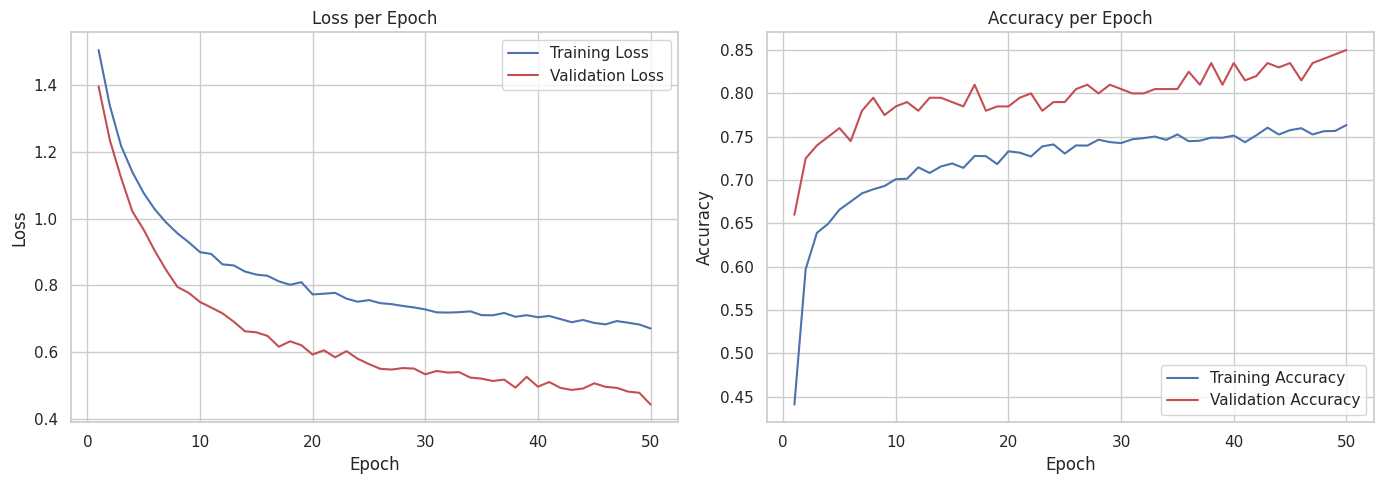

In [35]:
# Plot training history
plot_training_history(history)


Test Metrics:
Accuracy:   0.8500
Precision:  0.8517
Recall:     0.8500
F1 Score:   0.8493

Classification Report:
              precision    recall  f1-score   support

       Apple     0.6667    0.7000    0.6829        20
      Banana     0.9091    1.0000    0.9524        20
       Grape     0.9444    0.8500    0.8947        20
       Mango     0.8333    0.7500    0.7895        20
  Strawberry     0.9048    0.9500    0.9268        20

    accuracy                         0.8500       100
   macro avg     0.8517    0.8500    0.8493       100
weighted avg     0.8517    0.8500    0.8493       100



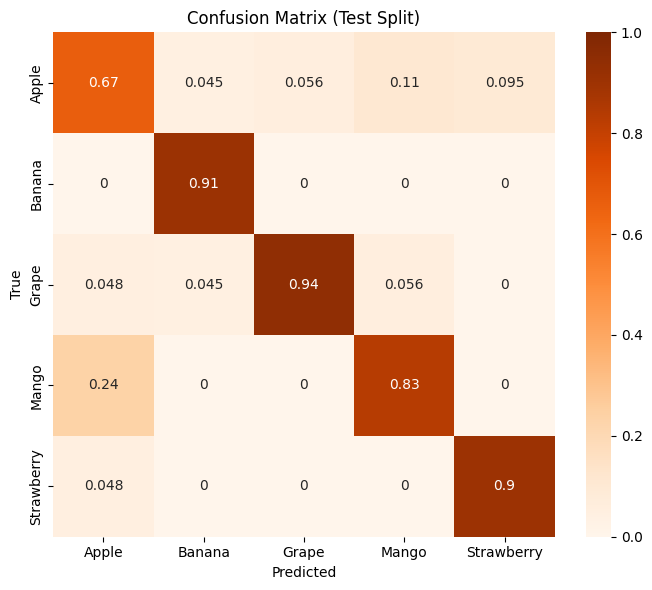

In [38]:
# Final test evaluation
evaluate_on_test(model, test_loader, device, class_names=train_dataset.classes)

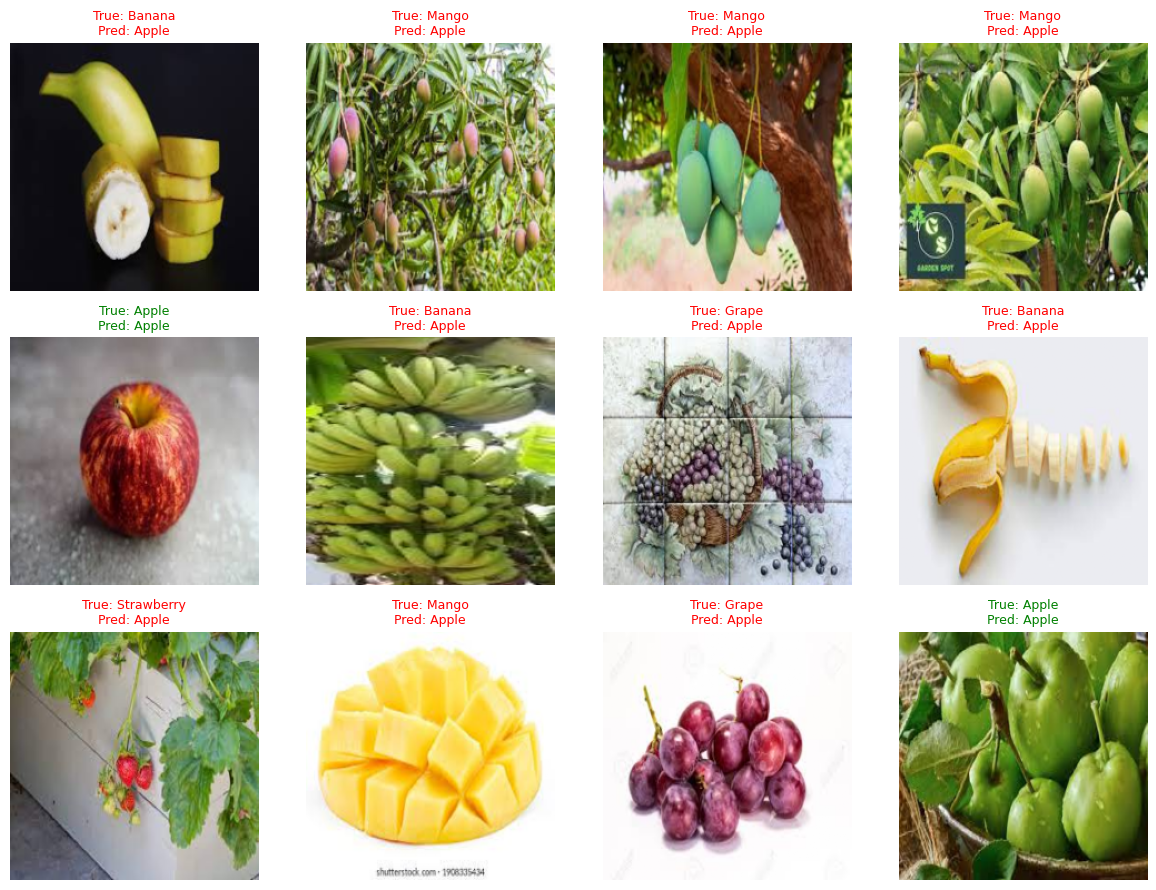

In [37]:
show_random_test_predictions(model, test_loader, device, class_names=train_dataset.classes)